In [1]:
import sys
import argparse
import numpy as np
import scipy.signal as sp
import processing as pr
import matplotlib.pyplot as plt
from ruamel.yaml import YAML as ym

sys.path.append("../preprocessing")
from generate_chirp import generate_chirp

# Widgets are only needed if you want to use the interactive plot at the end
# Installation instructions: https://ipywidgets.readthedocs.io/en/latest/user_install.html
import ipywidgets as widgets

import scipy.fft

In [13]:
# == Use this to plot the last recorded data ==
# yaml_file = "../config/default.yaml"
# bin_file = "../data/rx_samps.bin"

#bin_file = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20211105/20211105-drone-cont2-239pm-longerwingspan.bin"
#yaml_file = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20211105/config-300mhz-cont1-newformat.yaml"

# == Or this to plot saved data ==
#prefix = "../data/20211118_194414"

prefix = "../data/20220603_140048"
yaml_file = prefix + "_config.yaml"
bin_file = prefix + "_rx_samps.dat"

n_stack = 1 # Do additional stacking in this notebook - set > 1 to enable
zero_sample_idx = 640 # The index of the 0 distance sample -- will change with platforms and config changes -- if unsure, just set to 0

In [14]:
# Initialize Constants
yaml = ym()
with open(yaml_file) as stream:
    config = yaml.load(stream)
    sample_rate = config["PLOT"]["sample_rate"]    # Hertz
    sig_speed = config["PLOT"]["sig_speed"]

    #expected_n_rxs = int(config['CHIRP']['num_pulses'] / config['CHIRP']['num_presums'])
    
    rx_len_samples = int(config['CHIRP']['rx_duration'] * config['GENERATE']['sample_rate'])
    
rx_samps = bin_file

--- Loaded constants from config.yaml ---
--- Building Chirp ---
len(tx_sig): 800


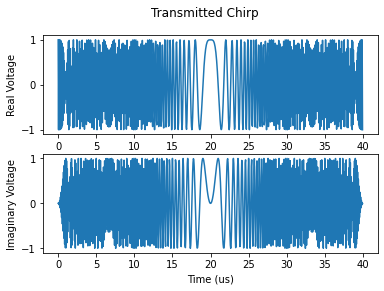

In [15]:
# Read and plot RX/TX
# This cell loads all of the data - it can take a while with a large file. You don't need to re-run this cell if you only change n_stack
_, tx_sig = generate_chirp(config)
pr.plotChirpVsTime(tx_sig, 'Transmitted Chirp', sample_rate)
print(f"len(tx_sig): {len(tx_sig)}")

rx_sig = pr.extractSig(rx_samps)

(200.0, 600.0)

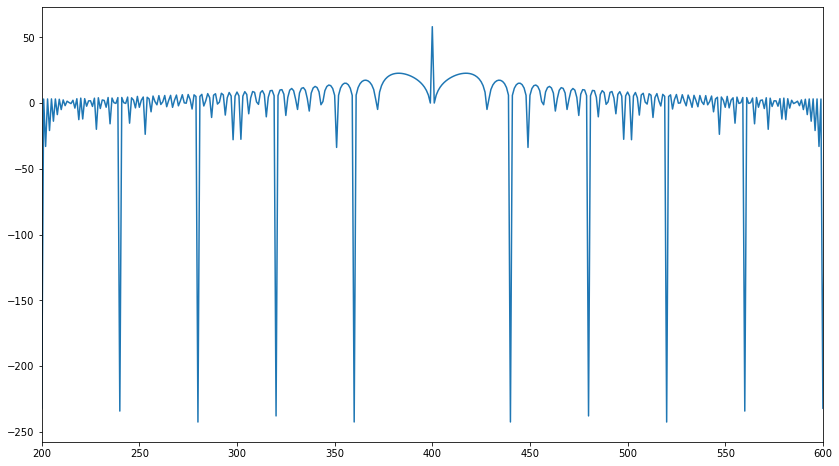

In [16]:
tx_sig_autocorr = sp.correlate(tx_sig, tx_sig, mode='same', method='auto')
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(20*np.log10(np.abs(tx_sig_autocorr)))
ax.set_xlim(len(tx_sig_autocorr)/2 - 200, len(tx_sig_autocorr)/2 + 200)

In [17]:
# Coherent stacking

n_rxs = len(rx_sig) // rx_len_samples
rx_sig_reshaped = np.transpose(np.reshape(rx_sig, (n_rxs, rx_len_samples), order='C'))
print(f"len(rx_sig): {len(rx_sig)}")
print(f"n_rxs: {n_rxs}")
print(f"rx_sig shape: {np.shape(rx_sig)}")
print(f"rx_sig_reshaped shape: {np.shape(rx_sig_reshaped)}")

xcorr_results = np.zeros(((rx_len_samples-len(tx_sig))+1, np.shape(rx_sig_reshaped)[1]//n_stack), dtype=np.csingle)
print(f"shape of xcorr_results: {np.shape(xcorr_results)}")

for res_idx in range(np.shape(xcorr_results)[1]):
    stacked = np.mean(rx_sig_reshaped[:,res_idx*n_stack:(res_idx+1)*n_stack], axis=1)
    xcorr_results[:, res_idx] = sp.correlate(stacked, tx_sig, mode='valid', method='auto')

len(rx_sig): 6828000
n_rxs: 5690
rx_sig shape: (6828000,)
rx_sig_reshaped shape: (1200, 5690)
shape of xcorr_results: (401, 5690)


IndexError: index 640 is out of bounds for axis 0 with size 401

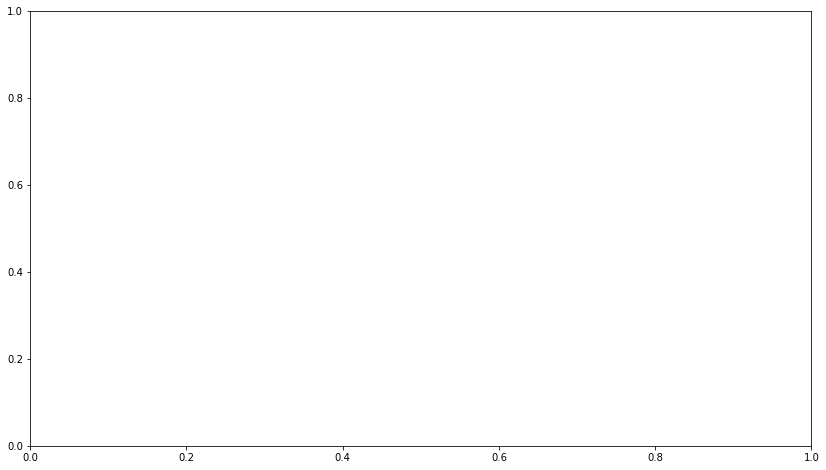

In [18]:
fig, ax = plt.subplots(figsize=(14,8), facecolor='white')
slow_time = np.linspace(0, config['CHIRP']['pulse_rep_int']*config['CHIRP']['num_presums']*n_rxs, np.shape(xcorr_results)[1])
distance_to_reflector = np.linspace(0, np.shape(xcorr_results)[0]/sample_rate, np.shape(xcorr_results)[0]) * sig_speed / 2
distance_to_reflector = distance_to_reflector - distance_to_reflector[zero_sample_idx]

p = ax.pcolormesh(slow_time, distance_to_reflector, 20*np.log10(np.abs(xcorr_results)), shading='thermal')
clb = fig.colorbar(p)
clb.set_label('Power [dB]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Relative distance to target [m]')
ax.set_ylim(0,1000)
ax.set_ylim(0,500)
plt.show()

In [ ]:
# Must enable widgets (see imports block) for this to work

def plot_timestep(idx):
    fig, ax = plt.subplots(figsize=(14,8))
    ax.plot(distance_to_reflector, 20*np.log10(np.abs(xcorr_results[:,idx])))
    ax.set_ylim(20,100)
    ax.set_xlim(-10, 50)
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Power [dB]')
    ax.grid()
    return fig, ax
    
widgets.interact(plot_timestep, idx=widgets.IntSlider(min=0, max=np.shape(xcorr_results)[1]-1, step=1, value=0))

In [ ]:
# Must enable widgets (see imports block) for this to work

def plot_stack_amount(n):
    
    stacked = np.mean(rx_sig_reshaped[:,500:500+n], axis=1)
    xcorr_res_tmp = sp.correlate(stacked, tx_sig, mode='valid', method='direct')
    
    fig, ax = plt.subplots(figsize=(14,8))
    ax.plot(distance_to_reflector, 20*np.log10(np.abs(xcorr_res_tmp)))
    ax.set_ylim(0,100)
    ax.set_xlim(-20, 50)
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Power [dB]')
    ax.grid()
    return fig, ax
    
widgets.interact(plot_stack_amount, n=widgets.IntSlider(min=1, max=400, step=1, value=0))

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(np.real(rx_sig_reshaped[:,500]))

In [ ]:
f, t, Sxx = sp.spectrogram(rx_sig_reshaped[:,0], sample_rate, return_onesided=False)
plt.pcolormesh(t, scipy.fft.fftshift(f), scipy.fft.fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()